# Import libraries and load data

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pickle
from xgboost import XGBClassifier


# Load data
df_model_data = pd.read_excel('../data/processed/PSP_model_data.xlsx')
df_fees = pd.read_excel('../data/raw/PSP_Fees.xlsx')

# Show the first few rows of each dataset to understand the structure
df_model_data.head(), df_fees.head()

(   index                tmsp  country  amount  success         PSP  \
 0      0 2019-01-01 00:01:11  Germany      89        0     UK_Card   
 1      1 2019-01-01 00:01:17  Germany      89        1     UK_Card   
 2      2 2019-01-01 00:02:49  Germany     238        0     UK_Card   
 3      3 2019-01-01 00:03:13  Germany     238        1     UK_Card   
 4      4 2019-01-01 00:04:33  Austria     124        0  Simplecard   
 
    3D_secured    card  previous_failure  attempts  fee  weekday  hour  \
 0           0    Visa                 0         1  1.0  Tuesday     0   
 1           0    Visa                 1         2  3.0  Tuesday     0   
 2           1  Diners                 0         1  1.0  Tuesday     0   
 3           1  Diners                 1         2  3.0  Tuesday     0   
 4           0  Diners                 0         1  0.5  Tuesday     0   
 
   time_of_day  log_amount         country_PSP PSP_3D_secured amount_group  
 0       Night    4.499810     Germany_UK_Card   

# Functions for model evaluation

In [2]:
def evaluate_classification_model(y_true, y_pred):
    """
    Evaluates the performance of a classification model and prints the results.
    
    Parameters:
        y_true (array-like): True labels
        y_pred (array-like): Predicted labels
        
    Returns:
        print statements
         
    Example usage:
    evaluate_classification_model(y_test, y_pred)
    """
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)
    class_report = classification_report(y_true, y_pred)

    # Print evaluation metrics
    print("Accuracy:", accuracy)
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(class_report)

def plot_auc_roc(y_true, y_prob):
    """
    Plots the AUC-ROC curve given the true labels and predicted probabilities.
    
    Parameters:
        y_true (array-like): True labels
        y_prob (array-like): Predicted probabilities
        
    Returns:
        None
        
    Example usage:
    plot_auc_roc(y_test, y_prob)
    """
    # Compute ROC curve and ROC area for each class
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = roc_auc_score(y_true, y_prob)

    # Plot the ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

# Basismodell: Logistic regression

In [3]:
# Drop columns that won't be used in the model
drop_columns = ['index', 'tmsp', 'hour', 'log_amount','fee']
df_model_logistic = df_model_data.drop(columns=drop_columns)

# Encode categorical variables
label_columns = ['country', 'PSP', 'card', 'weekday', 'time_of_day', 'country_PSP', 'PSP_3D_secured', 'amount_group']
label_encoder = LabelEncoder()
for col in label_columns:
    df_model_logistic[col] = label_encoder.fit_transform(df_model_logistic[col].astype(str))

# Split the data into training and test sets
X = df_model_logistic.drop('success', axis=1)
y = df_model_logistic['success']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Show the first few rows of the scaled training data
pd.DataFrame(X_train_scaled, columns=X_train.columns).head()

,country,amount,PSP,3D_secured,card,previous_failure,attempts,weekday,time_of_day,country_PSP,PSP_3D_secured,amount_group
0,-0.015475,-0.647278,-0.248014,-0.561389,1.481725,1.100824,0.128401,-1.540419,-0.444938,-0.101105,-0.366451,1.218614
1,-0.015475,-0.470256,-0.248014,-0.561389,-0.057004,-0.908410,-0.674167,1.382030,0.446840,-0.101105,-0.366451,1.218614
2,1.564492,-0.626452,-2.373362,-0.561389,-0.057004,-0.908410,-0.674167,0.894955,0.446840,0.640776,-2.441463,1.218614
3,1.564492,0.748067,-0.248014,-0.561389,-0.057004,1.100824,4.141246,1.382030,-0.444938,1.382657,-0.366451,-1.235409
4,1.564492,-0.980494,-0.248014,-0.561389,-1.595733,-0.908410,-0.674167,-0.566269,-1.336716,1.382657,-0.366451,1.218614


/Users/christopheressmann/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/christopheressmann/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/christopheressmann/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

Accuracy: 0.7970640745883754
Confusion Matrix:
[[8036    0]
 [2046    0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89      8036
           1       0.00      0.00      0.00      2046

    accuracy                           0.80     10082
   macro avg       0.40      0.50      0.44     10082
weighted avg       0.64      0.80      0.71     10082


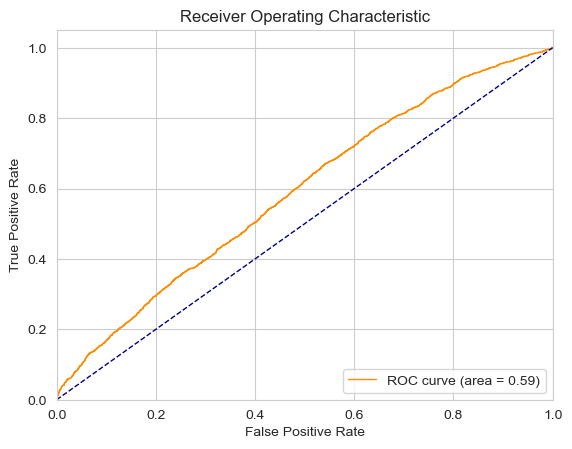

In [4]:
# Initialize and train the logistic regression model
log_reg_model = LogisticRegression(random_state=42)
log_reg_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = log_reg_model.predict(X_test_scaled)

# Get the probabilities of success
y_prob = log_reg_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate the model
evaluate_classification_model(y_test, y_pred)
plot_auc_roc(y_test, y_prob)

# Feature importance

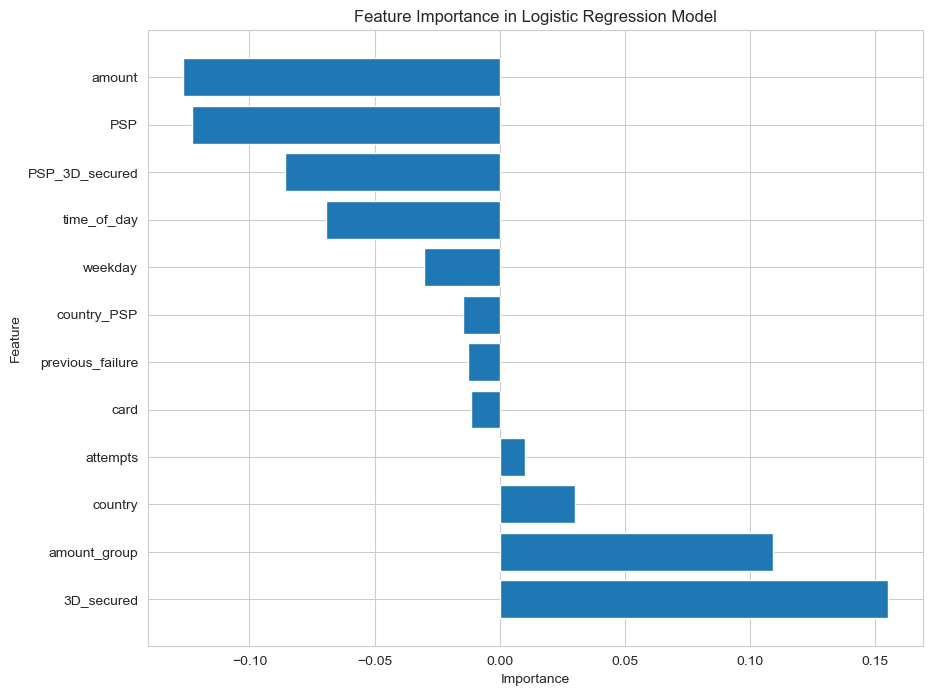

In [5]:
# Get the feature importances from the logistic regression model
feature_importance = log_reg_model.coef_[0]

# Create a DataFrame for the feature importances
df_feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
})

# Sort the DataFrame by the importances
df_feature_importance = df_feature_importance.sort_values('Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 8))
plt.barh(df_feature_importance['Feature'], df_feature_importance['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Logistic Regression Model')
plt.show()

# XGBoost classifier

In [6]:
# Drop columns that won't be used in the model
drop_columns = ['index', 'tmsp', 'fee', 'log_amount']
df_model_xgboost = df_model_data.drop(columns=drop_columns)

# Encode categorical variables
label_columns = ['country', 'PSP', 'card', 'weekday', 'time_of_day', 'PSP_3D_secured',
                 'country_PSP', 'amount_group', 'previous_failure']
label_encoder = LabelEncoder()
for col in label_columns:
    df_model_xgboost[col] = label_encoder.fit_transform(df_model_xgboost[col].astype(str))

# Split the data into training and test sets
X = df_model_xgboost.drop('success', axis=1)
y = df_model_xgboost['success']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

Accuracy: 0.7950487979052606
Confusion Matrix:
[[9791  255]
 [2328  229]]
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.97      0.88     10046
           1       0.47      0.09      0.15      2557

    accuracy                           0.80     12603
   macro avg       0.64      0.53      0.52     12603
weighted avg       0.74      0.80      0.73     12603


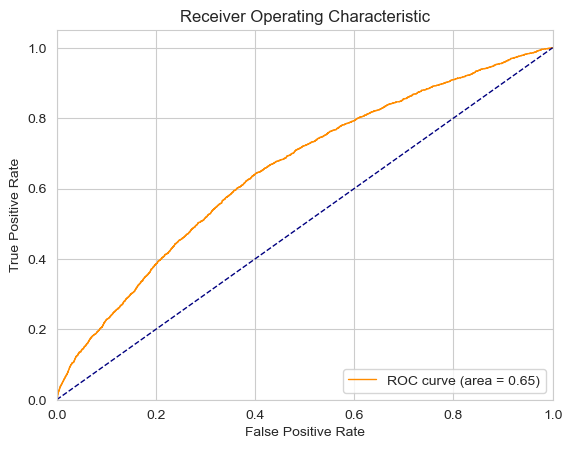

In [7]:
# Initialize and train the XGBoost model
xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_xgb = xgb_model.predict(X_test)

# Get the probabilities of success
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Evaluate the model
evaluate_classification_model(y_test, y_pred_xgb)
plot_auc_roc(y_test, y_prob_xgb)

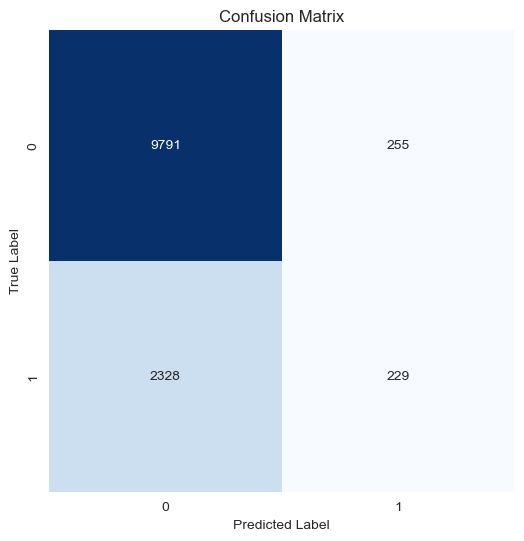

In [8]:
# Plot the confusion matrix
plt.figure(figsize=(6, 6))
plt.title('Confusion Matrix')
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt='d', cmap='Blues', cbar=False)

# Achsentitel hinzufügen
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.show()

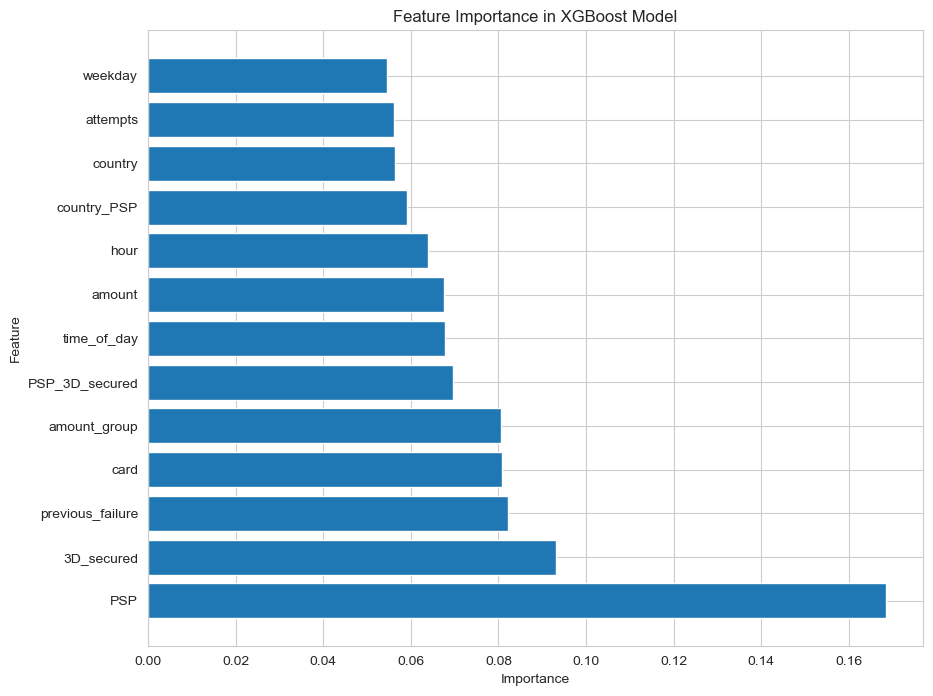

In [17]:
# Get the feature importances from the XGBoost model
feature_importance_xgb = xgb_model.feature_importances_

# Create a DataFrame for the feature importances
df_feature_importance_xgb = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance_xgb
})

# Sort the DataFrame by the importances
df_feature_importance_xgb = df_feature_importance_xgb.sort_values('Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 8))
plt.barh(df_feature_importance_xgb['Feature'], df_feature_importance_xgb['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in XGBoost Model')

plt.savefig('../results/figures/feature_importance_xgb.png')
plt.show()

# Hyperparameter tuning

In [10]:
# Define hyperparameter space
param_grid = {
    'n_estimators': [50,75,100,125,150],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 7],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

In [14]:
# Initialise GridSearch
grid_search = GridSearchCV(xgb_model, param_grid, scoring='f1', cv=3, verbose=1, n_jobs=-1)

# Execute GridSearch
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 900 candidates, totalling 2700 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, ma...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=125,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 0.9, 1.0],
                         'learning_rate': [0.01, 0.05, 0.1, 0.2],
                         'max_depth': [3, 4, 5, 6, 7],
                         'n_estimators': [50, 75, 100, 125, 150],
                         'subsample': [0.8, 0.9, 1.0]},
             scoring='f1', verbose=1)

Beste Hyperparameter: {'colsample_bytree': 0.9, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 150, 'subsample': 0.8}
Accuracy: 0.7898119495358248
Confusion Matrix:
[[9697  349]
 [2300  257]]
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.97      0.88     10046
           1       0.42      0.10      0.16      2557

    accuracy                           0.79     12603
   macro avg       0.62      0.53      0.52     12603
weighted avg       0.73      0.79      0.73     12603


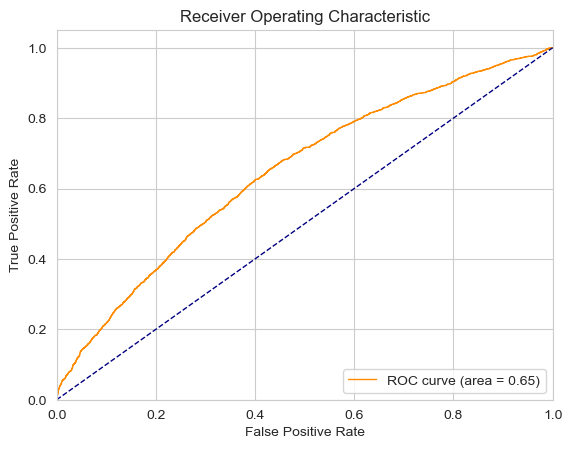

In [15]:
# Show best hyperparameters
print("Beste Hyperparameter:", grid_search.best_params_)

# Make predictions with the best hyperparameters
xgb_model = grid_search.best_estimator_
y_pred = xgb_model.predict(X_test)

# Evaluate the model
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]
evaluate_classification_model(y_test, y_pred)
plot_auc_roc(y_test, y_prob_xgb)

In [13]:
# Save models to results/models/
with open('../results/models/log_reg_model.pkl', 'wb') as f:
    pickle.dump(log_reg_model, f)
    
with open('../results/models/xgb_model.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)
    
# Save test data to data/processed/
X_test.to_csv('../data/processed/X_test_xgb.csv', index=False)